# Baseline CLIP Evaluation

This notebook evaluates the **CLIP baseline** (pre-trained, no fine-tuning) on the food recipe dataset.

**Hypothesis H1:** The fine-tuned model improves text↔image alignment compared to the CLIP baseline, measured with retrieval metrics (R@K, MRR).

**This notebook (M0 Baseline):**
- Loads pre-trained CLIP model (no fine-tuning)
- Generates embeddings for test set images and captions
- Evaluates retrieval performance:
  - **Text → Image**: For each caption, retrieve top-K images
  - **Image → Text**: For each image, retrieve top-K captions
- Computes metrics: R@1, R@5, R@10, MRR
- Saves results for comparison with fine-tuned models

**Inputs:**
- `fine-tuning-zone/datasets/train_manifest.csv` (for optional indexing)
- `fine-tuning-zone/datasets/test_manifest.csv` (for evaluation)
- `fine-tuning-zone/images/` and `fine-tuning-zone/augmented_images/` (images)

**Outputs:**
- `fine-tuning-zone/experiments/baseline/results_baseline.json` — Metrics and metadata
- `fine-tuning-zone/experiments/baseline/examples_top5.json` — Qualitative examples


## 1. Setup and Configuration


In [4]:
import os
import io
import json
import hashlib
import time
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError
from dotenv import load_dotenv
from tqdm import tqdm

# CLIP imports from transformers
try:
    from transformers import CLIPModel, CLIPProcessor
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("⚠ transformers not available. Install with: pip install transformers")

# Load environment variables
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent

ENV_PATHS = [
    PROJECT_ROOT / "notebooks" / ".env",
    PROJECT_ROOT / "app" / ".env",
    PROJECT_ROOT / ".env",
]

env_loaded = False
for env_path in ENV_PATHS:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded .env from: {env_path}")
        env_loaded = True
        break

if not env_loaded:
    print("⚠ No .env file found, trying default load_dotenv()...")
    load_dotenv()

# MinIO Configuration
MINIO_USER = os.getenv("MINIO_USER")
MINIO_PASSWORD = os.getenv("MINIO_PASSWORD")
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT")

# Bucket configuration
FINE_TUNING_BUCKET = "fine-tuning-zone"
DATASETS_PREFIX = "datasets"
IMAGES_PREFIX = "images"
AUGMENTED_IMAGES_PREFIX = "augmented_images"
EXPERIMENTS_PREFIX = "experiments"

# Input/Output paths
TRAIN_MANIFEST_KEY = f"{DATASETS_PREFIX}/train_manifest.csv"
TEST_MANIFEST_KEY = f"{DATASETS_PREFIX}/test_pairs_positive.csv"
DATASET_REPORT_KEY = f"{DATASETS_PREFIX}/dataset_report.json"

# Model configuration
MODEL_NAME = "openai/clip-vit-base-patch32"  # CLIP ViT-B/32 baseline from Hugging Face
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32  # Batch size for embedding generation

# Evaluation configuration
K_VALUES = [1, 5, 10]  # R@1, R@5, R@10
COMPUTE_MRR = True

# Output paths
RUN_ID = f"baseline_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}"
RESULTS_DIR = f"{EXPERIMENTS_PREFIX}/baseline"
RESULTS_KEY = f"{RESULTS_DIR}/results_baseline.json"
EXAMPLES_KEY = f"{RESULTS_DIR}/examples_top5.json"

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Device: {DEVICE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  K values: {K_VALUES}")
print(f"  Run ID: {RUN_ID}")


✓ Loaded .env from: c:\Users\DOCT\Documents\UNI\ADSDB\adsdb-multimodal-food-data-management\app\.env
Configuration:
  Model: openai/clip-vit-base-patch32
  Device: cpu
  Batch Size: 32
  K values: [1, 5, 10]
  Run ID: baseline_20260102_193545


C:\Users\DOCT\AppData\Local\Temp\ipykernel_14296\365599882.py:78: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN_ID = f"baseline_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}"


## 2. Initialize MinIO Client


In [2]:
# Initialize S3/MinIO client
session = boto3.session.Session(
    aws_access_key_id=MINIO_USER,
    aws_secret_access_key=MINIO_PASSWORD,
    region_name="us-east-1"
)
s3 = session.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    config=Config(signature_version="s3v4", s3={"addressing_style": "path"})
)

def ensure_bucket_exists(bucket: str) -> bool:
    """Create bucket if it doesn't exist."""
    try:
        s3.head_bucket(Bucket=bucket)
        return True
    except ClientError as e:
        error_code = e.response.get("Error", {}).get("Code", "")
        if error_code in ("404", "NoSuchBucket"):
            try:
                s3.create_bucket(Bucket=bucket)
                print(f"✓ Created bucket '{bucket}'")
                return True
            except ClientError as create_error:
                print(f"✗ Failed to create bucket '{bucket}': {create_error}")
                return False
        return False

# Verify buckets
print("Checking buckets...")
ensure_bucket_exists(FINE_TUNING_BUCKET)
print("✓ Buckets ready")


Checking buckets...
✓ Buckets ready


## 3. Load Test Dataset


In [5]:
def load_csv_from_minio(bucket: str, key: str) -> pd.DataFrame:
    """Load CSV file from MinIO into a DataFrame."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(io.BytesIO(obj["Body"].read()))
        print(f"✓ Loaded {len(df)} rows from s3://{bucket}/{key}")
        return df
    except ClientError as e:
        print(f"✗ Failed to load s3://{bucket}/{key}: {e}")
        return pd.DataFrame()

# Load test manifest
print("Loading test manifest...")
test_df = load_csv_from_minio(FINE_TUNING_BUCKET, TEST_MANIFEST_KEY)

if test_df.empty:
    raise RuntimeError(f"Could not load test manifest from s3://{FINE_TUNING_BUCKET}/{TEST_MANIFEST_KEY}")

print(f"\nTest dataset shape: {test_df.shape}")
print(f"Unique recipes: {test_df['recipe_id'].nunique()}")
print(f"Unique images: {test_df['image_key'].nunique()}")
print(f"Unique captions: {test_df['caption'].nunique()}")

print(f"\nTest dataset preview:")
display(test_df.head())


Loading test manifest...
✓ Loaded 103 rows from s3://fine-tuning-zone/datasets/test_pairs_positive.csv

Test dataset shape: (103, 3)
Unique recipes: 54
Unique images: 103
Unique captions: 54

Test dataset preview:


,recipe_id,image_key,caption
0,004a63989e,images/image$adsdb-multimodal-food-data-manage...,Lighter Spicy Garlic Shrimp
1,002481e577,images/image$adsdb-multimodal-food-data-manage...,Quick & Easy Chicken Parmigiana
2,002481e577,images/image$adsdb-multimodal-food-data-manage...,Quick & Easy Chicken Parmigiana
3,002481e577,images/image$adsdb-multimodal-food-data-manage...,Quick & Easy Chicken Parmigiana
4,0044818076,images/image$adsdb-multimodal-food-data-manage...,Noodles With Spicy Peanut Sauce


## 4. Load CLIP Model


In [6]:
if not TRANSFORMERS_AVAILABLE:
    raise ImportError("transformers library not available. Install with: pip install transformers")

print(f"Loading CLIP model: {MODEL_NAME}")
print(f"Device: {DEVICE}")

# Load processor and model from transformers
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()  # Set to evaluation mode

# Get model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model is frozen (baseline, no fine-tuning)")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CLIP model: openai/clip-vit-base-patch32
Device: cpu


c:\Users\DOCT\Documents\UNI\ADSDB\adsdb-multimodal-food-data-management\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DOCT\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package i


✓ Model loaded successfully
  Total parameters: 151,277,313
  Trainable parameters: 151,277,313
  Model is frozen (baseline, no fine-tuning)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


## 5. Helper Functions for MinIO Image Loading


In [7]:
def load_image_from_minio(bucket: str, key: str) -> Optional[Image.Image]:
    """Load an image from MinIO."""
    try:
        obj = s3.get_object(Bucket=bucket, Key=key)
        img = Image.open(io.BytesIO(obj["Body"].read()))
        img.load()
        return img.convert("RGB")
    except Exception as e:
        print(f"⚠ Failed to load image {key}: {e}")
        return None

def get_image_path_in_minio(image_key: str) -> Tuple[str, str]:
    """
    Determine bucket and full key for an image.
    
    Images can be in:
    - fine-tuning-zone/images/...
    - fine-tuning-zone/augmented_images/...
    """
    bucket = FINE_TUNING_BUCKET
    
    # Check if it's already a full path or just a key
    if image_key.startswith("images/") or image_key.startswith("augmented_images/"):
        key = image_key
    else:
        # Try images first, then augmented_images
        key = f"{IMAGES_PREFIX}/{image_key}"
    
    return bucket, key


## 6. Generate Embeddings


In [8]:
def generate_image_embeddings(
    df: pd.DataFrame, 
    model, 
    processor, 
    device: str, 
    batch_size: int = 32
) -> Tuple[np.ndarray, List[str]]:
    """
    Generate image embeddings for all images in the dataset.
    
    Returns:
        embeddings: numpy array of shape (n_images, embedding_dim)
        image_keys: list of image keys in the same order
    """
    model.eval()
    embeddings = []
    image_keys = []
    failed_keys = []
    
    # Get unique images
    unique_images = df["image_key"].unique()
    
    print(f"Generating embeddings for {len(unique_images)} unique images...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(unique_images), batch_size)):
            batch_keys = unique_images[i:i+batch_size]
            batch_images = []
            valid_keys = []
            
            # Load batch of images
            for img_key in batch_keys:
                bucket, key = get_image_path_in_minio(img_key)
                img = load_image_from_minio(bucket, key)
                if img is not None:
                    batch_images.append(img)
                    valid_keys.append(img_key)
                else:
                    failed_keys.append(img_key)
            
            if not batch_images:
                continue
            
            # Process images with processor
            inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)
            
            # Get image embeddings
            outputs = model.get_image_features(**inputs)
            batch_emb = F.normalize(outputs, p=2, dim=1)  # L2 normalize
            
            embeddings.append(batch_emb.cpu().numpy())
            image_keys.extend(valid_keys)
    
    if failed_keys:
        print(f"⚠ Failed to load {len(failed_keys)} images")
    
    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(image_keys)} image embeddings (shape: {embeddings.shape})")
    
    return embeddings, image_keys

def generate_text_embeddings(
    texts: List[str], 
    model, 
    processor, 
    device: str, 
    batch_size: int = 32
) -> np.ndarray:
    """
    Generate text embeddings for all captions.
    
    Returns:
        embeddings: numpy array of shape (n_texts, embedding_dim)
    """
    model.eval()
    embeddings = []
    
    print(f"Generating embeddings for {len(texts)} texts...")
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            
            # Process texts with processor
            inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
            
            # Get text embeddings
            outputs = model.get_text_features(**inputs)
            batch_emb = F.normalize(outputs, p=2, dim=1)  # L2 normalize
            
            embeddings.append(batch_emb.cpu().numpy())
    
    embeddings = np.vstack(embeddings) if embeddings else np.array([])
    print(f"✓ Generated {len(texts)} text embeddings (shape: {embeddings.shape})")
    
    return embeddings

# Generate embeddings
print("=" * 60)
print("Generating Embeddings")
print("=" * 60)

start_time = time.time()

# Image embeddings
image_embeddings, image_keys = generate_image_embeddings(
    test_df, model, processor, DEVICE, BATCH_SIZE
)

# Text embeddings
unique_captions = test_df["caption"].unique().tolist()
text_embeddings = generate_text_embeddings(unique_captions, model, processor, DEVICE, BATCH_SIZE)

embedding_time = time.time() - start_time
print(f"\n✓ Embedding generation complete in {embedding_time:.2f} seconds")
print(f"  Image embeddings: {image_embeddings.shape}")
print(f"  Text embeddings: {text_embeddings.shape}")

# Create mapping dictionaries for lookup
image_key_to_idx = {key: idx for idx, key in enumerate(image_keys)}
caption_to_idx = {caption: idx for idx, caption in enumerate(unique_captions)}


Generating Embeddings
Generating embeddings for 103 unique images...


100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


✓ Generated 103 image embeddings (shape: (103, 512))
Generating embeddings for 54 texts...


100%|██████████| 2/2 [00:00<00:00, 15.99it/s]

✓ Generated 54 text embeddings (shape: (54, 512))

✓ Embedding generation complete in 2.47 seconds
  Image embeddings: (103, 512)
  Text embeddings: (54, 512)


In [11]:
def compute_recall_at_k(scores: np.ndarray, ground_truth_indices: List[int], k: int) -> float:
    """
    Compute Recall@K.
    
    Args:
        scores: similarity scores for all candidates (1D array)
        ground_truth_indices: list of correct candidate indices
        k: top-K to consider
    
    Returns:
        recall@k: 1.0 if any ground truth is in top-K, else 0.0
    """
    if len(ground_truth_indices) == 0:
        return 0.0
    
    top_k_indices = np.argsort(scores)[-k:][::-1]  # Top K, highest first
    top_k_set = set(top_k_indices)
    
    # Check if any ground truth is in top-K
    for gt_idx in ground_truth_indices:
        if gt_idx in top_k_set:
            return 1.0
    
    return 0.0

def compute_mrr(scores: np.ndarray, ground_truth_indices: List[int]) -> float:
    """
    Compute Mean Reciprocal Rank.
    
    Args:
        scores: similarity scores for all candidates (1D array)
        ground_truth_indices: list of correct candidate indices
    
    Returns:
        mrr: 1/rank of first correct result, or 0.0 if none found
    """
    if len(ground_truth_indices) == 0:
        return 0.0
    
    # Sort by score (descending)
    sorted_indices = np.argsort(scores)[::-1]
    
    # Find rank of first ground truth
    for rank, idx in enumerate(sorted_indices, start=1):
        if idx in ground_truth_indices:
            return 1.0 / rank
    
    return 0.0

def evaluate_text_to_image(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    k_values: List[int],
    should_compute_mrr: bool = True
) -> Dict:
    """
    Evaluate Text → Image retrieval.
    
    For each caption, retrieve top-K images. Correct if any image from the same recipe_id is in top-K.
    """
    print("\nEvaluating Text → Image retrieval...")
    
    # Group by caption to get all images for each caption
    caption_groups = test_df.groupby("caption")
    
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    
    for caption, group in tqdm(caption_groups, desc="Processing captions"):
        # Get text embedding
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        
        text_emb = text_embeddings[text_idx]
        
        # Compute similarities with all images
        similarities = image_embeddings @ text_emb  # (n_images,)
        
        # Get ground truth: all images from the same recipe_ids as this caption
        recipe_ids = group["recipe_id"].unique()
        ground_truth_indices = []
        
        for recipe_id in recipe_ids:
            recipe_images = test_df[test_df["recipe_id"] == recipe_id]["image_key"].unique()
            for img_key in recipe_images:
                img_idx = image_key_to_idx.get(img_key)
                if img_idx is not None:
                    ground_truth_indices.append(img_idx)
        
        # Remove duplicates
        ground_truth_indices = list(set(ground_truth_indices))
        
        if len(ground_truth_indices) == 0:
            continue
        
        # Compute metrics
        for k in k_values:
            recall = compute_recall_at_k(similarities, ground_truth_indices, k)
            recalls[f"R@{k}"].append(recall)
        
        if should_compute_mrr:
            mrr = compute_mrr(similarities, ground_truth_indices)
            mrr_scores.append(mrr)
    
    # Average metrics
    results = {}
    for k in k_values:
        results[f"R@{k}"] = float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0
    
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    
    return results

def evaluate_image_to_text(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    k_values: List[int],
    should_compute_mrr: bool = True
) -> Dict:
    """
    Evaluate Image → Text retrieval.
    
    For each image, retrieve top-K captions. Correct if caption from the same recipe_id is in top-K.
    """
    print("\nEvaluating Image → Text retrieval...")
    
    # Group by image_key to get all captions for each image
    image_groups = test_df.groupby("image_key")
    
    recalls = {f"R@{k}": [] for k in k_values}
    mrr_scores = [] if should_compute_mrr else None
    
    for img_key, group in tqdm(image_groups, desc="Processing images"):
        # Get image embedding
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        
        img_emb = image_embeddings[img_idx]
        
        # Compute similarities with all captions
        similarities = text_embeddings @ img_emb  # (n_texts,)
        
        # Get ground truth: all captions from the same recipe_ids as this image
        recipe_ids = group["recipe_id"].unique()
        ground_truth_indices = []
        
        for recipe_id in recipe_ids:
            recipe_captions = test_df[test_df["recipe_id"] == recipe_id]["caption"].unique()
            for caption in recipe_captions:
                cap_idx = caption_to_idx.get(caption)
                if cap_idx is not None:
                    ground_truth_indices.append(cap_idx)
        
        # Remove duplicates
        ground_truth_indices = list(set(ground_truth_indices))
        
        if len(ground_truth_indices) == 0:
            continue
        
        # Compute metrics
        for k in k_values:
            recall = compute_recall_at_k(similarities, ground_truth_indices, k)
            recalls[f"R@{k}"].append(recall)
        
        if should_compute_mrr:
            mrr = compute_mrr(similarities, ground_truth_indices)
            mrr_scores.append(mrr)
    
    # Average metrics
    results = {}
    for k in k_values:
        results[f"R@{k}"] = float(np.mean(recalls[f"R@{k}"])) if recalls[f"R@{k}"] else 0.0
    
    if should_compute_mrr and mrr_scores:
        results["MRR"] = float(np.mean(mrr_scores))
    
    return results


In [12]:
print("=" * 60)
print("Running Evaluation")
print("=" * 60)

eval_start_time = time.time()

# Text → Image retrieval
text_to_image_results = evaluate_text_to_image(
    test_df,
    text_embeddings,
    image_embeddings,
    caption_to_idx,
    image_key_to_idx,
    K_VALUES,
    COMPUTE_MRR
)

# Image → Text retrieval
image_to_text_results = evaluate_image_to_text(
    test_df,
    text_embeddings,
    image_embeddings,
    caption_to_idx,
    image_key_to_idx,
    K_VALUES,
    COMPUTE_MRR
)

eval_time = time.time() - eval_start_time

print("\n" + "=" * 60)
print("Evaluation Results")
print("=" * 60)

print("\n📊 Text → Image Retrieval:")
for metric, value in text_to_image_results.items():
    print(f"  {metric}: {value:.4f}")

print("\n📊 Image → Text Retrieval:")
for metric, value in image_to_text_results.items():
    print(f"  {metric}: {value:.4f}")

print(f"\n⏱ Evaluation time: {eval_time:.2f} seconds")


Running Evaluation

Evaluating Text → Image retrieval...


Processing captions: 100%|██████████| 54/54 [00:00<00:00, 5369.79it/s]



Evaluating Image → Text retrieval...


Processing images: 100%|██████████| 103/103 [00:00<00:00, 6248.66it/s]


Evaluation Results

📊 Text → Image Retrieval:
  R@1: 0.5741
  R@5: 0.7963
  R@10: 0.9444
  MRR: 0.6882

📊 Image → Text Retrieval:
  R@1: 0.6893
  R@5: 0.9126
  R@10: 0.9612
  MRR: 0.7958

⏱ Evaluation time: 0.03 seconds


## 9. Generate Qualitative Examples (Top-5)


## 8. Visualize Retrieval Results

Visualize qualitative examples showing top-5 retrievals for both directions:
- **Text → Image**: Show the 5 most similar images for sample captions
- **Image → Text**: Show the 5 most similar captions for sample images


Visualizing Retrieval Results

📝 Text → Image Retrieval (Top-5 images for each caption):
------------------------------------------------------------


C:\Users\DOCT\AppData\Local\Temp\ipykernel_14296\2061780828.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


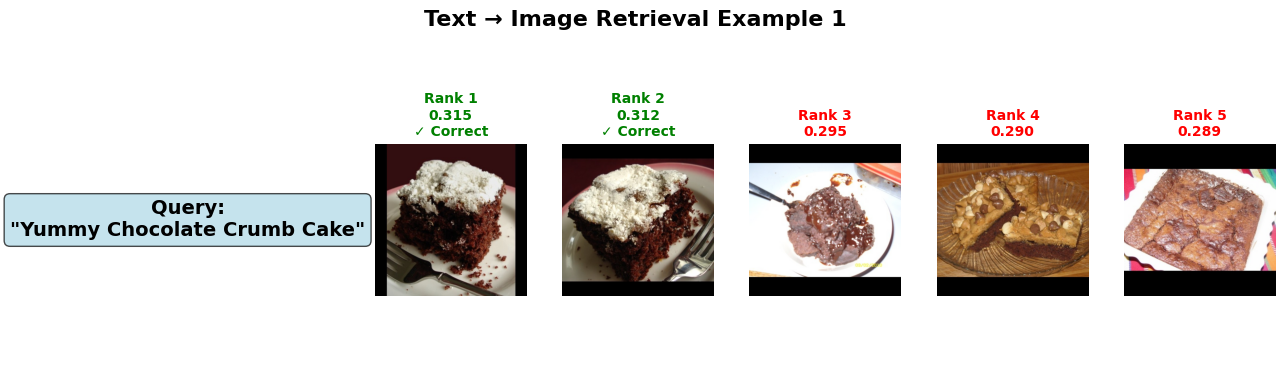

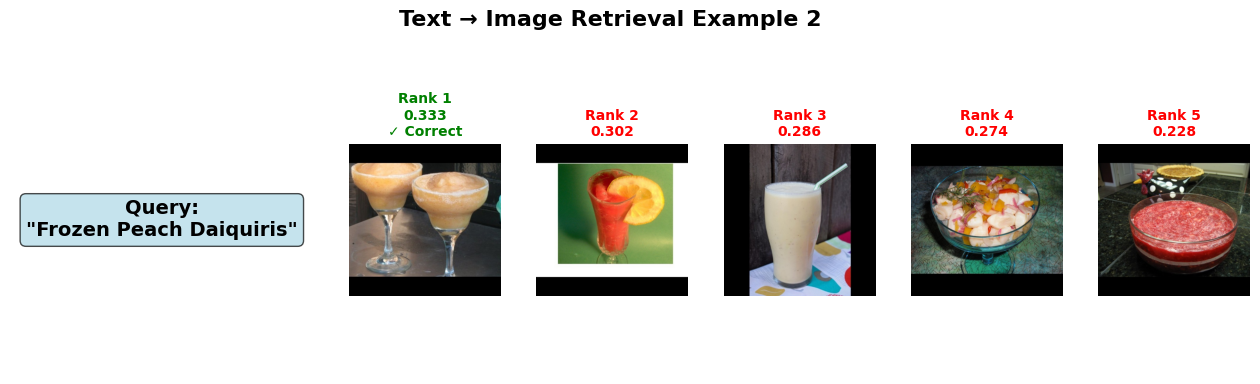

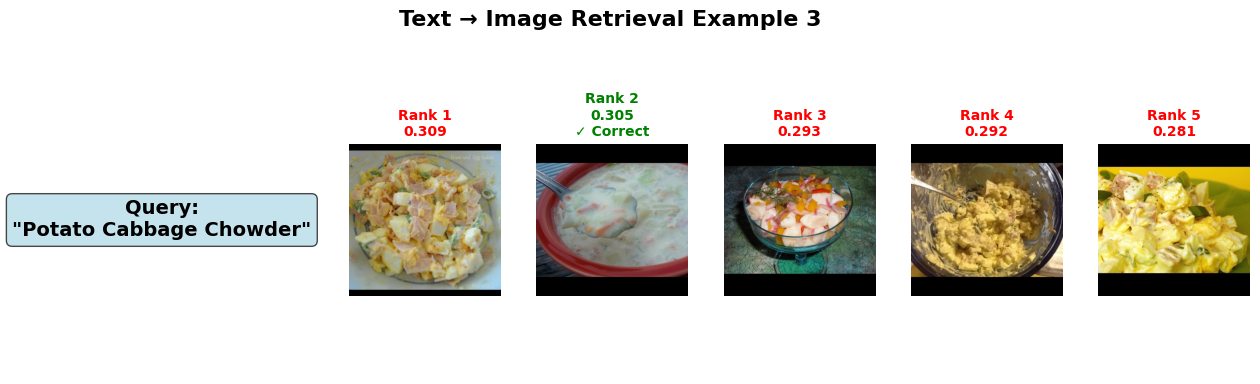



🖼️ Image → Text Retrieval (Top-5 captions for each image):
------------------------------------------------------------


C:\Users\DOCT\AppData\Local\Temp\ipykernel_14296\2061780828.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


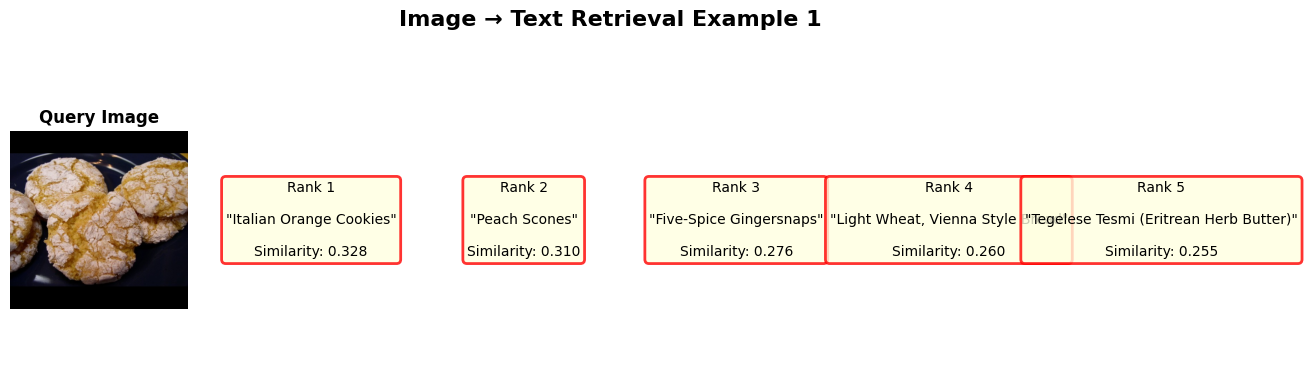

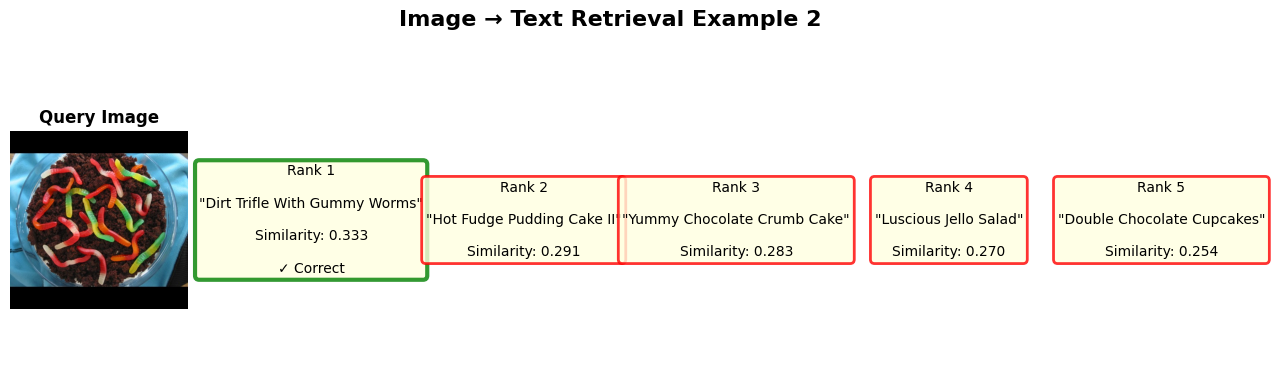

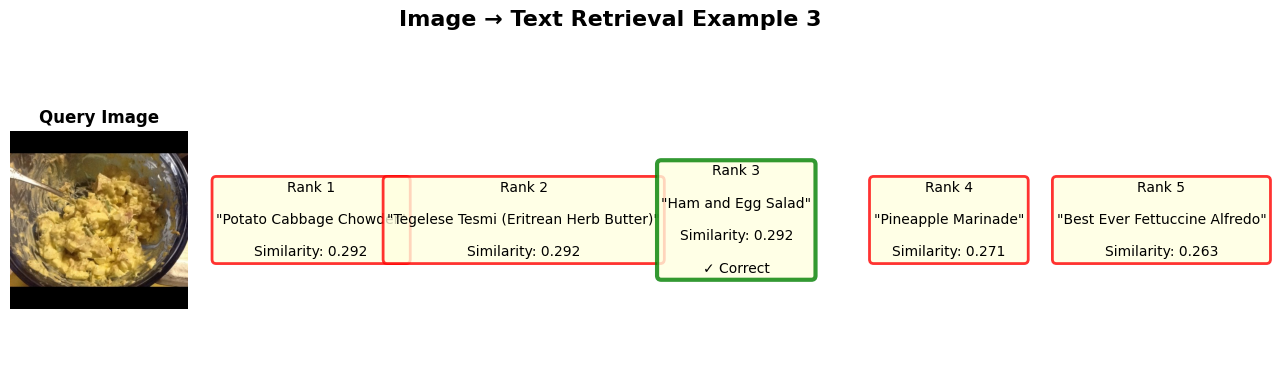

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec

def visualize_text_to_image_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    n_examples: int = 3
):
    """
    Visualize Text → Image retrieval: for each caption, show top-5 images.
    """
    # Sample random captions
    sample_captions = test_df["caption"].drop_duplicates().sample(
        min(n_examples, test_df["caption"].nunique()),
        random_state=42
    )
    
    for caption_idx, caption in enumerate(sample_captions):
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]  # Top 5, highest first
        
        # Get ground truth recipe_ids
        gt_recipe_ids = set(test_df[test_df["caption"] == caption]["recipe_id"].unique())
        
        # Create figure
        fig = plt.figure(figsize=(16, 4))
        gs = gridspec.GridSpec(1, 6, width_ratios=[2, 1, 1, 1, 1, 1], hspace=0.3)
        
        # Show query caption
        ax0 = fig.add_subplot(gs[0])
        ax0.text(0.5, 0.5, f'Query:\n"{caption}"', 
                ha='center', va='center', fontsize=14, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax0.axis('off')
        
        # Show top-5 images
        for i, img_idx in enumerate(top5_indices):
            img_key = image_keys[img_idx]
            bucket, key = get_image_path_in_minio(img_key)
            img = load_image_from_minio(bucket, key)
            
            if img is None:
                continue
            
            # Get recipe_id for this image
            img_recipe_ids = set(test_df[test_df["image_key"] == img_key]["recipe_id"].unique())
            is_correct = len(gt_recipe_ids & img_recipe_ids) > 0
            
            ax = fig.add_subplot(gs[i + 1])
            ax.imshow(img)
            ax.axis('off')
            
            # Color border: green if correct, red if incorrect
            border_color = 'green' if is_correct else 'red'
            border_width = 3 if is_correct else 2
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(border_width)
            
            # Title with similarity score
            similarity_score = similarities[img_idx]
            rank = i + 1
            title = f"Rank {rank}\n{similarity_score:.3f}"
            if is_correct:
                title += "\n✓ Correct"
            ax.set_title(title, fontsize=10, color=border_color, fontweight='bold')
        
        plt.suptitle(f'Text → Image Retrieval Example {caption_idx + 1}', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print()

def visualize_image_to_text_retrieval(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    n_examples: int = 3
):
    """
    Visualize Image → Text retrieval: for each image, show top-5 captions.
    """
    # Sample random images
    sample_images = test_df["image_key"].drop_duplicates().sample(
        min(n_examples, test_df["image_key"].nunique()),
        random_state=42
    )
    
    for img_idx_example, img_key in enumerate(sample_images):
        img_idx = image_key_to_idx.get(img_key)
        if img_idx is None:
            continue
        
        img_emb = image_embeddings[img_idx]
        similarities = text_embeddings @ img_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]  # Top 5, highest first
        
        # Get ground truth recipe_ids
        gt_recipe_ids = set(test_df[test_df["image_key"] == img_key]["recipe_id"].unique())
        
        # Load query image
        bucket, key = get_image_path_in_minio(img_key)
        query_img = load_image_from_minio(bucket, key)
        
        if query_img is None:
            continue
        
        # Create figure
        fig = plt.figure(figsize=(16, 4))
        gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 1], hspace=0.3)
        
        # Show query image
        ax0 = fig.add_subplot(gs[0])
        ax0.imshow(query_img)
        ax0.axis('off')
        ax0.set_title('Query Image', fontsize=12, fontweight='bold')
        
        # Show top-5 captions
        for i, text_idx in enumerate(top5_indices):
            caption = unique_captions[text_idx]
            
            # Get recipe_ids for this caption
            caption_recipe_ids = set(test_df[test_df["caption"] == caption]["recipe_id"].unique())
            is_correct = len(gt_recipe_ids & caption_recipe_ids) > 0
            
            ax = fig.add_subplot(gs[i + 1])
            ax.axis('off')
            
            # Color border: green if correct, red if incorrect
            border_color = 'green' if is_correct else 'red'
            border_width = 3 if is_correct else 2
            
            # Create text box
            similarity_score = similarities[text_idx]
            rank = i + 1
            text_content = f"Rank {rank}\n\n\"{caption}\"\n\nSimilarity: {similarity_score:.3f}"
            if is_correct:
                text_content += "\n\n✓ Correct"
            
            ax.text(0.5, 0.5, text_content,
                   ha='center', va='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='lightyellow', 
                            edgecolor=border_color, linewidth=border_width, alpha=0.8),
                   wrap=True)
        
        plt.suptitle(f'Image → Text Retrieval Example {img_idx_example + 1}', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print()

# Visualize results
print("=" * 60)
print("Visualizing Retrieval Results")
print("=" * 60)

print("\n📝 Text → Image Retrieval (Top-5 images for each caption):")
print("-" * 60)
visualize_text_to_image_retrieval(
    test_df,
    text_embeddings,
    image_embeddings,
    caption_to_idx,
    image_key_to_idx,
    n_examples=3
)

print("\n🖼️ Image → Text Retrieval (Top-5 captions for each image):")
print("-" * 60)
visualize_image_to_text_retrieval(
    test_df,
    text_embeddings,
    image_embeddings,
    caption_to_idx,
    image_key_to_idx,
    n_examples=3
)


In [13]:
def generate_top5_examples(
    test_df: pd.DataFrame,
    text_embeddings: np.ndarray,
    image_embeddings: np.ndarray,
    caption_to_idx: Dict[str, int],
    image_key_to_idx: Dict[str, int],
    n_examples: int = 5
) -> List[Dict]:
    """
    Generate qualitative examples showing top-5 retrievals.
    """
    examples = []
    
    # Sample random captions for examples
    sample_captions = test_df["caption"].drop_duplicates().sample(
        min(n_examples, test_df["caption"].nunique()),
        random_state=42
    )
    
    for caption in sample_captions:
        text_idx = caption_to_idx.get(caption)
        if text_idx is None:
            continue
        
        text_emb = text_embeddings[text_idx]
        similarities = image_embeddings @ text_emb
        top5_indices = np.argsort(similarities)[-5:][::-1]
        
        # Get ground truth recipe_id
        gt_recipe_ids = test_df[test_df["caption"] == caption]["recipe_id"].unique()
        
        # Get top-5 retrieved images
        top5_images = []
        for idx in top5_indices:
            img_key = image_keys[idx]
            img_recipe_ids = test_df[test_df["image_key"] == img_key]["recipe_id"].unique()
            is_correct = len(set(gt_recipe_ids) & set(img_recipe_ids)) > 0
            
            top5_images.append({
                "image_key": img_key,
                "recipe_id": img_recipe_ids[0] if len(img_recipe_ids) > 0 else None,
                "similarity": float(similarities[idx]),
                "is_correct": is_correct
            })
        
        examples.append({
            "query_type": "text_to_image",
            "query": caption,
            "ground_truth_recipe_ids": gt_recipe_ids.tolist(),
            "top5_results": top5_images
        })
    
    return examples

# Generate examples
print("Generating qualitative examples...")
examples = generate_top5_examples(
    test_df,
    text_embeddings,
    image_embeddings,
    caption_to_idx,
    image_key_to_idx,
    n_examples=5
)

print(f"✓ Generated {len(examples)} examples")


Generating qualitative examples...
✓ Generated 5 examples


## 10. Save Results to MinIO


In [14]:
def save_json_to_minio(data: Dict, bucket: str, key: str) -> bool:
    """Save dictionary as JSON to MinIO."""
    try:
        json_bytes = json.dumps(data, indent=2).encode("utf-8")
        
        s3.put_object(
            Bucket=bucket,
            Key=key,
            Body=json_bytes,
            ContentType="application/json",
        )
        
        size_kb = len(json_bytes) / 1024
        print(f"✓ Saved to s3://{bucket}/{key} ({size_kb:.1f} KB)")
        return True
    except Exception as e:
        print(f"✗ Failed to save: {e}")
        return False

# Create results dictionary
results = {
    "metadata": {
        "run_id": RUN_ID,
        "model": MODEL_NAME,
        "method": "baseline",
        "created_at": datetime.utcnow().isoformat() + "Z",
        "device": DEVICE,
        "batch_size": BATCH_SIZE,
        "random_seed": 42,
        "test_manifest": TEST_MANIFEST_KEY,
    },
    "model_info": {
        "total_parameters": total_params,
        "trainable_parameters": trainable_params,
        "frozen": True
    },
    "dataset_info": {
        "test_pairs": len(test_df),
        "test_recipes": test_df["recipe_id"].nunique(),
        "test_images": test_df["image_key"].nunique(),
        "test_captions": test_df["caption"].nunique(),
    },
    "metrics": {
        "text_to_image": text_to_image_results,
        "image_to_text": image_to_text_results,
    },
    "timing": {
        "embedding_generation_seconds": embedding_time,
        "evaluation_seconds": eval_time,
        "total_seconds": embedding_time + eval_time,
    },
}

# Save results
print("=" * 60)
print("Saving Results to MinIO")
print("=" * 60)

save_json_to_minio(results, FINE_TUNING_BUCKET, RESULTS_KEY)
save_json_to_minio({"examples": examples}, FINE_TUNING_BUCKET, EXAMPLES_KEY)

print(f"\n✅ Results saved successfully!")
print(f"  Results: s3://{FINE_TUNING_BUCKET}/{RESULTS_KEY}")
print(f"  Examples: s3://{FINE_TUNING_BUCKET}/{EXAMPLES_KEY}")

# Print summary
print("\n" + "=" * 60)
print("Summary")
print("=" * 60)
print(f"Run ID: {RUN_ID}")
print(f"Model: {MODEL_NAME} (baseline, no fine-tuning)")
print(f"\nText → Image:")
print(f"  R@1: {text_to_image_results.get('R@1', 0):.4f}")
print(f"  R@5: {text_to_image_results.get('R@5', 0):.4f}")
print(f"  R@10: {text_to_image_results.get('R@10', 0):.4f}")
if "MRR" in text_to_image_results:
    print(f"  MRR: {text_to_image_results['MRR']:.4f}")
print(f"\nImage → Text:")
print(f"  R@1: {image_to_text_results.get('R@1', 0):.4f}")
print(f"  R@5: {image_to_text_results.get('R@5', 0):.4f}")
print(f"  R@10: {image_to_text_results.get('R@10', 0):.4f}")
if "MRR" in image_to_text_results:
    print(f"  MRR: {image_to_text_results['MRR']:.4f}")


Saving Results to MinIO
✓ Saved to s3://fine-tuning-zone/experiments/baseline/results_baseline.json (1.0 KB)
✓ Saved to s3://fine-tuning-zone/experiments/baseline/examples_top5.json (7.8 KB)

✅ Results saved successfully!
  Results: s3://fine-tuning-zone/experiments/baseline/results_baseline.json
  Examples: s3://fine-tuning-zone/experiments/baseline/examples_top5.json

Summary
Run ID: baseline_20260102_193545
Model: openai/clip-vit-base-patch32 (baseline, no fine-tuning)

Text → Image:
  R@1: 0.5741
  R@5: 0.7963
  R@10: 0.9444
  MRR: 0.6882

Image → Text:
  R@1: 0.6893
  R@5: 0.9126
  R@10: 0.9612
  MRR: 0.7958


C:\Users\DOCT\AppData\Local\Temp\ipykernel_14296\1992615965.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",
